# Technical Exercise 3.
## Part 1: Dataset Preparation and Fine-Tuning

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import kaggle

import torch
import evaluate
from datasets import Dataset as HFDataset

from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

### Step 1: Download the IMDB Dataset

Download the dataset from Kaggle

In [3]:
#!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p ../../data --unzip

Read the data into `pandas`

In [4]:
path = "../../data"
imdb_df = pd.read_csv(f"{path}/IMDB Dataset.csv")
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Step 2: Data Preprocessing
Clean and preprocess the dataset

In [5]:
imdb_df['sentiment'] = imdb_df['sentiment'].map({'positive': 1, 'negative': 0})
imdb_df = imdb_df[['review', 'sentiment']]
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Split the dataset into training (80%), validation (10%), and testing (10%)

In [6]:
train_data, temp_data = train_test_split(imdb_df, test_size=0.2, random_state=420)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=420)

train_data = HFDataset.from_dict({"text": train_data["review"], "label": train_data["sentiment"]})
val_data = HFDataset.from_dict({"text": val_data["review"], "label": val_data["sentiment"]})
test_data = HFDataset.from_dict({"text": test_data["review"], "label": test_data["sentiment"]})

### Step 3: Model Selection and Tokenization
Fine-tuning `distilbert-base-uncased` for the task

In [7]:
model_name = "distilbert-base-uncased"
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Available device: {device}")

Available device: mps


Get the tokenizer and create a method for tokenization

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
def tokenize(text_set): return tokenizer(text_set["text"], padding="max_length", truncation=True, max_length=256)

Tokenize the data

In [9]:
train_data = train_data.map(tokenize, batched=True)
val_data = val_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

### Step 4: Fine-Tune the Model
Load the model to the device

In [10]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)
print(f"Model on device: {device}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model on device: mps


Define evaluation function using evaluate

In [11]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

# Define evaluation function using evaluate
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    acc = accuracy.compute(predictions=predictions, references=labels)
    prec = precision.compute(predictions=predictions, references=labels, average="binary")
    rec = recall.compute(predictions=predictions, references=labels, average="binary")
    f1_score = f1.compute(predictions=predictions, references=labels, average="binary")
    
    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1_score["f1"]
    }

Define trainer

In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics
)

/Users/juhis/miniconda3/envs/data.ml.440/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train the model

In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.205400,0.228509,0.912000,0.901239,0.926354,0.913624
2,0.196100,0.247040,0.913800,0.904392,0.926354,0.915241


TrainOutput(global_step=2500, training_loss=0.19708657882213593, metrics={'train_runtime': 2029.7504, 'train_samples_per_second': 39.414, 'train_steps_per_second': 1.232, 'total_flos': 5298695946240000.0, 'train_loss': 0.19708657882213593, 'epoch': 2.0})

Evaluate the model performance on test set

In [14]:
test_results = trainer.evaluate(test_data)
for metric, value in test_results.items():
    print(f"{metric}: {value}")

eval_loss: 0.21740780770778656
eval_accuracy: 0.9246
eval_precision: 0.9103829451243585
eval_recall: 0.9389250814332247
eval_f1: 0.9244337542593706
eval_runtime: 42.0081
eval_samples_per_second: 119.025
eval_steps_per_second: 3.737
epoch: 2.0


### Step 5: Save and Upload the Model to Hugging Face
Save the model and tokenizer locally

In [15]:
path = "./models"
model.save_pretrained(f"{path}/imdb_model")
tokenizer.save_pretrained(f"{path}/imdb_tokenizer")
print("Save successfull")

Save successfull


Uploaded the models to HuggingFace via `huggingface-cli`.

You can verify the repo at https://huggingface.co/Juh6973/imdb-distilbert/tree/main

Test loading the model from HuggingFace.

In [20]:
repo_name = "Juh6973/imdb-distilbert"
custom_model = DistilBertForSequenceClassification.from_pretrained(repo_name, subfolder="imdb_model")
custom_tokenizer = DistilBertTokenizer.from_pretrained(repo_name, subfolder="imdb_tokenizer")

model.safetensors:  59%|#####8    | 157M/268M [00:00<?, ?B/s]

imdb_tokenizer/tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

imdb_tokenizer/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

imdb_tokenizer/special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## Part 2: API Development and Testing
### Step 6: Set Up the Backend API 
Can be found in the repository in file *api.py*

### Step 7: Load Models
Can be found in the repository in file *api.py*

### Step 8: Test the API Locally
Test the api with Postman, curl and python request library

Postman
Works in the same manner as the other options

curl - custom

In [1]:
!curl -X 'POST' 'http://127.0.0.1:8000/analyze/' \
-H 'Content-Type: application/json' \
-d '{"text": "The movie was absolutely fantastic!", "model": "custom"}'

{"sentiment_analysis":{"sentiment":"positive","confidence_score":0.9950377345085144}}

curl - llama

In [6]:
!curl -X 'POST' 'http://127.0.0.1:8000/analyze/' \
-H 'Content-Type: application/json' \
-d '{"text": "This is the worst film I have ever watched.", "model": "llama"}'

{"sentiment_analysis":{"sentiment":"negative","confidence_score":0.95}}

In [5]:
import requests

# API URL
url = "http://127.0.0.1:8000/analyze/"

# Test with the custom fine-tuned model
data_custom = {
    "text": "The movie was absolutely fantastic!",
    "model": "custom"
}
response_custom = requests.post(url, json=data_custom)
print("Custom Model Response:", response_custom.json())

# Test with Llama model (Groq API)
data_llama = {
    "text": "This is the worst film I have ever watched.",
    "model": "llama"
}
response_llama = requests.post(url, json=data_llama)
print("Llama Model Response:", response_llama.json())

Custom Model Response: {'sentiment_analysis': {'sentiment': 'positive', 'confidence_score': 0.9950377345085144}}
Llama Model Response: {'sentiment_analysis': {'sentiment': 'negative', 'confidence_score': 0.9}}


### Step 9: Define the Llama 3 Prompt
Prompt can be found in *api.py* in the `system_prompt` variable (Also here):

`system_prompt = "You are a data analyst API capable of sentiment analysis that responds in JSON. The JSON schema should be strictly {\"sentiment_analysis\": {\"sentiment\": \"string (positive, negative, neutral)\", \"confidence_score\": \"number (0-1)\"}}"`

### Step 10: Test with Both Models
The proof that both models work is shown in step 8.

### Step 11: React UI Design
UI code can be found in *ui.py*. Screenshot of UI:

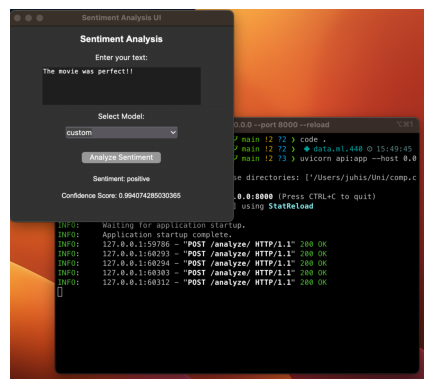

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display an image
path = "../images"
img = mpimg.imread(f"{path}/ui_example.png")  # Replace with your image path
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

### Step 12: Submit GitHub Repository
The Github repository can be found here: https://github.com/juh6973/bert_chatbot